In [618]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
import os

In [619]:
# setting directories
## change this to the directory where you have stored the data for the project
base_dir = "C:\\Users\\lshah\\OneDrive\\Documents\\Projects\\WM_chunking"
behav_dir = os.path.join(base_dir, "data", "behavioural", "raw")

# setting some default variables
return_subjs = ["s10", "s11", "s12", "s14", "s15", "s16", "s17", "s18", "s19", "s20", "s21", "s22", "s23", "s24", "s25"]

In [651]:
def clean_df(subject):
    """
    Takes in the subject name and does initial cleaning (removes unwanted columns)
    Args:
        subject (str) - name assigned to the subject 
    """
    
    # get subject directory
    subj_dir = os.path.join(behav_dir, subject)
    # load the dataframe
    df_sub = pd.read_csv(os.path.join(subj_dir, f'WMC_{subject}.csv'), converters={'response_time': pd.eval})
    
    # deleting the Unnamed columns
    ## get all the columns with Unnamed 
    filter_col = [col for col in df_sub if col.startswith('Unnamed')]
    ## drop all the unnamed columns
    df_sub = df_sub.drop(filter_col, axis = 1)
    
    # loop over runs and add a column representing the trial number
    runs = np.unique(df_sub.run_number.values)
    df = pd.DataFrame()
    for r in runs:
        # get the section of the dataframe corresponding to the current run
        df_run = df_sub.loc[df_sub.run_number == r].copy()
        df_run.reset_index(drop = True, inplace = True)
        TN_value = np.arange(0, len(df_run.index))
        df_run.insert(loc = 0, column='TN', value=TN_value)
        # calculate reaction times for each trial
        rt = []
        rt.append(np.nan)
        rt.append(df_run["response_time"][1][0] - 7)
        for t in df_run.index[2:]:
            
            if len(df_run["response_time"][t]) == 0:
                rt.append(np.nan)
            else:
                ipi_0 = df_run["response_time"][t][0] - (df_run['response_time'][t-2][5] + 6 + 1)
                if ipi_0 <0:
                    ipi_0 = np.nan
                rt.append(ipi_0)
                
        df_run.loc[:, "ipi_0"] = rt

        df = pd.concat([df, df_run])      
    return df

def merge_df(subject_list):
    """
    takes in a list of subjects and merge their behavioural data into 1 dataframe
    Args: 
        subject_list (list) - list containing names assigned to subjects
        
    returns:
        merged_df (pd.DataFrame) -  a dataframe with merged data for all the subjects
    """
    
    df_list = []
    for s in subject_list:
        
        # clean the subject data
        df_subject = clean_df(s)
        
        # add a column to the dataframe containing the subject name
        df_subject["subject"] = s
        
        # append it to the dataframes list
        df_list.append(df_subject)
        
    # merge dataframe
    merged_df = pd.concat(df_list, axis = 0, ignore_index = True)
    
    ## drop 1234 column (not all subjects have that)
    merged_df = merged_df.drop(['1234'], axis = 1)
    
    return merged_df
#____________________________________________________________________________________________
# calculate reaction times and inter-press-intervales
def calc_rt(data):
    """
    calculates reaction time (time of the first press)
    """
    return

def calc_ipi(data):
    """
    calculates inter-press-intervals and returns a specific dataframe to plot the ipis
    Args:
        data (pd.DataFrame) - the dataframe with all the data (can be a subject's dataframe or the merged dataframe)
    Returns:
        data_ipi (pd.DataFrame) - the dataframe to be used for analysis of ipis
    """
    # get execution trials
    data_exe = data.loc[data["phase_type"] == 1]  
    # get the response times
    response_times = data_exe["response_time"]
    response_times = response_times.values.tolist()
    response_times = np.array(response_times)
    # calculate ipis for each trial
    ipis = np.diff(response_times)
    
    # convert ipis to a temporary dataframe and append it to the original dataframe
    df_ipis = pd.DataFrame(ipis, columns = ['ipi_1', 'ipi_2', 'ipi_3', 'ipi_4', 'ipi_5'])
    # reset indices before merging
    df_ipis.reset_index(drop = True, inplace = True)
    data_exe.reset_index(drop = True, inplace = True)
    
    # joing the two dataframes
    data_exe = data_exe.join(df_ipis) 
    
    data_tmp = data_exe[['subject', 'ipi_0', 'ipi_1', 'ipi_2', 'ipi_3', 'ipi_4', 'ipi_5', 'chunk', 'recall_dir']]
    data_ipi = pd.melt(data_tmp, id_vars=['subject', 'chunk', 'recall_dir'], value_vars=['ipi_1', 'ipi_2', 'ipi_3', 'ipi_4', 'ipi_5'])
    data_ipi = data_ipi.rename(columns={'variable': 'ipi', 'value': 'time'})
    data_ipi.time = data_ipi.time.astype(float)
    return data_ipi
#____________________________________________________________________________________________
# calculate accuracy and error-rate for each serial place
def calc_acc(data):
    return
def calc_acc_serial(data):
    return
#____________________________________________________________________________________________

In [652]:
df_final = merge_df(return_subjs)
# df_final

In [653]:
aa = df_final.loc[df_final.subject == "s24"]
a = calc_ipi(aa)


<AxesSubplot:xlabel='ipi', ylabel='time'>

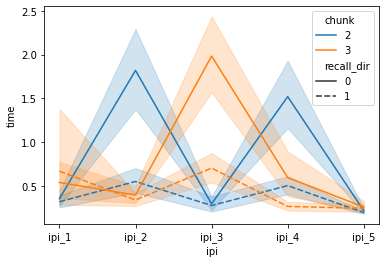

In [654]:
sns.lineplot(data = a, hue = "chunk", x = "ipi", y = "time", style = "recall_dir", palette = 'tab10')